In [1]:
import torch
import torch.nn.functional as F
import torchmetrics
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import itertools

In [2]:
# ucitavanje grafa
with open('../preprocessing/graph.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
from torch_geometric.utils import from_networkx
data = from_networkx(G)

In [4]:
# podela cvorova na trening, validacioni i test skup
nodes = list(G.nodes)
train_nodes, test_nodes = train_test_split(nodes, test_size=0.2, random_state=42)
train_nodes, val_nodes = train_test_split(train_nodes, test_size=0.2, random_state=42)

In [5]:
# kreiranje maske za skupove
train_mask = torch.tensor([True if node in train_nodes else False for node in range(len(G.nodes))])
val_mask = torch.tensor([True if node in val_nodes else False for node in range(len(G.nodes))])
test_mask = torch.tensor([True if node in test_nodes else False for node in range(len(G.nodes))])

In [6]:
# atributi
node_features = [list(G.nodes[node].values())[:-1] for node in G.nodes]
node_features = torch.tensor(node_features, dtype=torch.float)

# ciljne promenljive
labels = np.array([G.nodes[node]['target'] for node in G.nodes])
labels = torch.tensor(labels, dtype=torch.float)

# dodajemo i labelu koja ce da oznacava da cvor ne pripada nijednoj ego mrezi 
# -> kako bismo mogli da dodelimo odgovarajucu tezinu zbog nebalansiranosti klasa :)
no_class_nodes = (labels.sum(dim=1) == 0).float()
dummy_class = no_class_nodes.unsqueeze(1)
labels = torch.cat([labels, dummy_class], dim=1)


data.x = node_features
data.y = labels
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

In [8]:
# Hiperparametri
hyperparameters = {
    'hidden_channels': [32, 64],
    'dropout_rate': [0.2, 0.5],
    'num_epochs': [50, 100]
}
learning_rate = 0.01
weight_decay = 5e-4
# early_stopping_threshold = 20  # Broj epoha pre zaustavljanja

In [9]:
# metrike
device = 'cuda' if torch.cuda.is_available() else 'cpu'
precision = torchmetrics.Precision(num_labels=labels.shape[1], average='macro', task='multilabel').to(device)
recall = torchmetrics.Recall(num_labels=labels.shape[1], average='macro', task='multilabel').to(device)
f1 = torchmetrics.F1Score(num_labels=labels.shape[1], average='macro', task='multilabel').to(device)

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ego_to_index_df = pd.read_csv("../preprocessing/ego_to_index.csv", index_col=0)
ego_to_index = ego_to_index_df.to_dict(orient='index')
ego_to_index = {int(ego_id): int(index['index']) for ego_id, index in ego_to_index.items()}

# Funkcija za prikaz matricu konfuzije
def plot_confusion_matrix(y_true, y_pred, num_classes):
    # Izračunavanje multilabel matrice konfuzije
    conf_matrix = multilabel_confusion_matrix(y_true, y_pred)
    
    # Prikaz za svaku klasu
    for i in range(num_classes):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix[i], annot=True, fmt='d', cmap='Blues')
        if i == 10:
            plt.title(f'Matrica konfuzije za čvorove koji ne pripadaju nijednoj ego mreži')
        else:
            plt.title(f'Matrica konfuzije za ego mrežu čvora {[key for key, value in ego_to_index.items() if value == i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

In [11]:
train_labels = labels[data.train_mask]  
nodes_in_ego_train = train_labels.sum(dim=0)

total_train_nodes_num = train_labels.shape[0]
class_weights = total_train_nodes_num / (nodes_in_ego_train + 1e-6)  

print(f'Nodes in ego (train only): {nodes_in_ego_train}')
print(f'Class weights: {class_weights}')

Nodes in ego (train only): tensor([168., 290., 133.,  94., 112.,  33., 498., 474.,  68.,  36., 736.])
Class weights: tensor([15.3810,  8.9103, 19.4286, 27.4894, 23.0714, 78.3030,  5.1888,  5.4515,
        38.0000, 71.7778,  3.5109])


In [12]:
def train():
    model.train()
    optimizer.zero_grad()
    
    pred_train = model(data)[data.train_mask].to(device)
    loss = criterion(pred_train, data.y[data.train_mask].float().to(device))
    loss.backward()
    optimizer.step()
    
    preds_train = (torch.sigmoid(pred_train) > 0.5).float()
    acc_train = (preds_train == data.y[data.train_mask].to(device)).float().mean()
    precision_train = precision(pred_train.to(device), data.y[data.train_mask].to(device))
    recall_train = recall(pred_train.to(device), data.y[data.train_mask].to(device))
    f1_train = f1(pred_train.to(device), data.y[data.train_mask].to(device))
    
    return loss, acc_train.item(), precision_train.item(), recall_train.item(), f1_train.item()

In [13]:
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        pred_val = model(data)[mask].to(device)
        loss_val = criterion(pred_val, data.y[mask].float().to(device))
        
        preds_val = (torch.sigmoid(pred_val) > 0.5).float()
        acc_val = (preds_val == data.y[mask].to(device)).float().mean()
        precision_val = precision(pred_val.to(device), data.y[mask].to(device))
        recall_val = recall(pred_val.to(device), data.y[mask].to(device))
        f1_val = f1(pred_val.to(device), data.y[mask].to(device))

        if torch.equal(mask, data.test_mask):
            # Vizualizacija matrice konfuzije na test skupu
            plot_confusion_matrix(data.y[data.test_mask].to(device), preds_val.to(device), labels.shape[1])
        
        
    return loss_val, acc_val.item(), precision_val.item(), recall_val.item(), f1_val.item()

In [14]:
# treniranje i podešavanje hiperparametara
best_params = None
best_loss = float('inf')

# kreiranje sve kombinacije hiperparametara
param_combinations = list(itertools.product(
    hyperparameters['hidden_channels'],
    hyperparameters['dropout_rate'],
    hyperparameters['num_epochs']
))

for params in param_combinations:
    hidden_channels, dropout_rate, num_epochs = params
    print(f'Testing parameters: {params}')

    # Inicijalizacija modela, optimizatora i kriterijuma
    model = None
    model = GCN(in_channels=node_features.shape[1], hidden_channels=hidden_channels, out_channels=labels.shape[1], dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

    for epoch in range(num_epochs):
        loss_train, acc_train, precision_train, recall_train, f1_train = train()
        
        if epoch % 10 == 0:
            print(f'[Train] Epoch: {epoch}, Loss: {loss_train:.4f}, Accuracy: {acc_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}')
        
        if epoch == num_epochs-1:
            loss_val, acc_val, precision_val, recall_val, f1_val = evaluate(data.val_mask)
            print(f'[Validate] Epoch: {epoch}, Loss: {loss_val:.4f}, Accuracy: {acc_val:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1: {f1_val:.4f}')
            if loss_val < best_loss:
                best_loss = loss_val
                best_params = params

print(f'Best parameters: {best_params}, with loss: {best_loss:.4f}')

Testing parameters: (32, 0.2, 50)
[Train] Epoch: 0, Loss: 1.3289, Accuracy: 0.4845, Precision: 0.1291, Recall: 0.4400, F1: 0.1557
[Train] Epoch: 10, Loss: 0.6074, Accuracy: 0.8615, Precision: 0.4500, Recall: 0.9892, F1: 0.5652
[Train] Epoch: 20, Loss: 0.3134, Accuracy: 0.9434, Precision: 0.6410, Recall: 0.9790, F1: 0.7373
[Train] Epoch: 30, Loss: 0.2464, Accuracy: 0.9458, Precision: 0.6494, Recall: 0.9809, F1: 0.7413
[Train] Epoch: 40, Loss: 0.2277, Accuracy: 0.9478, Precision: 0.6627, Recall: 0.9816, F1: 0.7524
[Validate] Epoch: 49, Loss: 0.2525, Accuracy: 0.9483, Precision: 0.6704, Recall: 0.9828, F1: 0.7582
Testing parameters: (32, 0.2, 100)
[Train] Epoch: 0, Loss: 1.3202, Accuracy: 0.5411, Precision: 0.1271, Recall: 0.5982, F1: 0.1763
[Train] Epoch: 10, Loss: 0.5976, Accuracy: 0.8688, Precision: 0.4221, Recall: 0.9884, F1: 0.5489
[Train] Epoch: 20, Loss: 0.3130, Accuracy: 0.9455, Precision: 0.6558, Recall: 0.9796, F1: 0.7444
[Train] Epoch: 30, Loss: 0.2479, Accuracy: 0.9462, Precis

Testing the best model with parameters: (32, 0.2, 50)


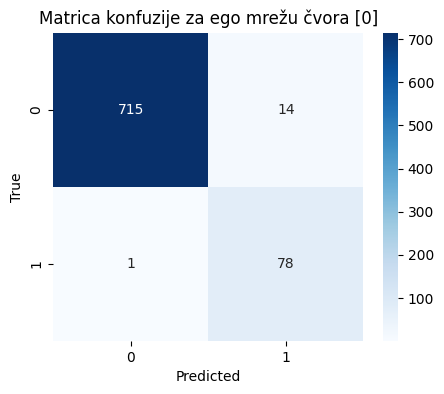

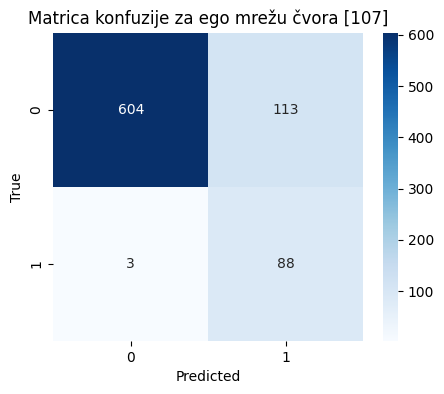

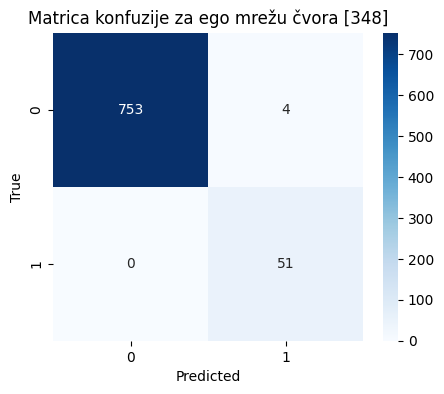

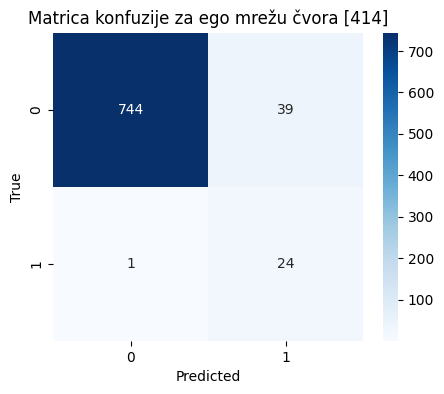

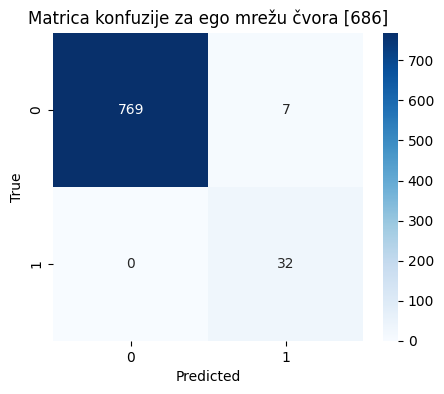

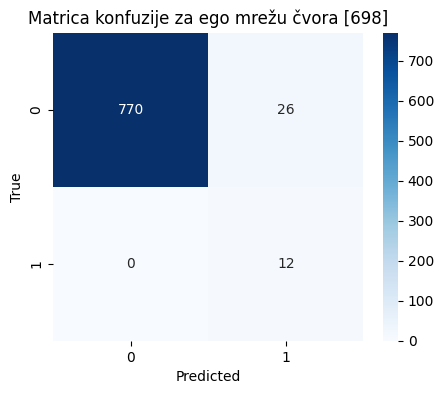

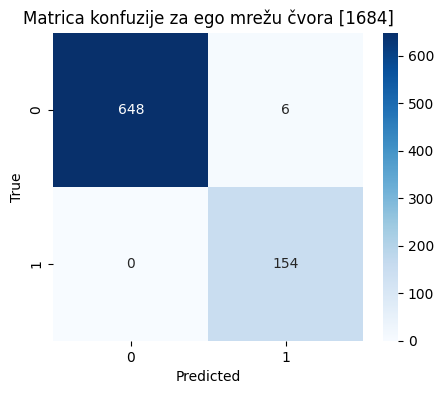

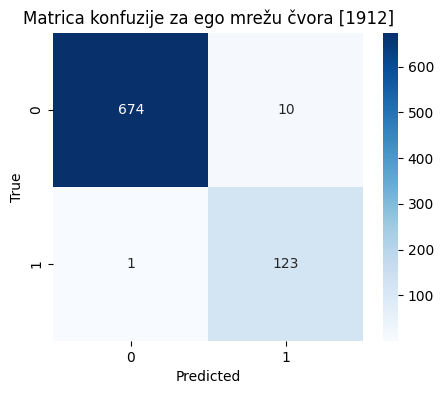

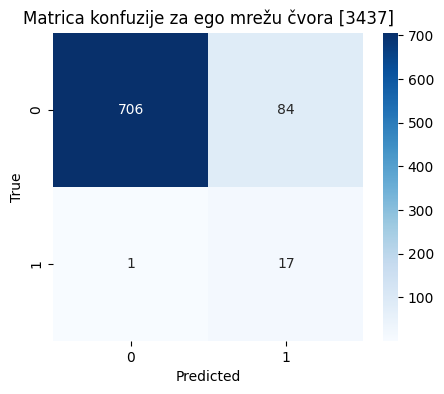

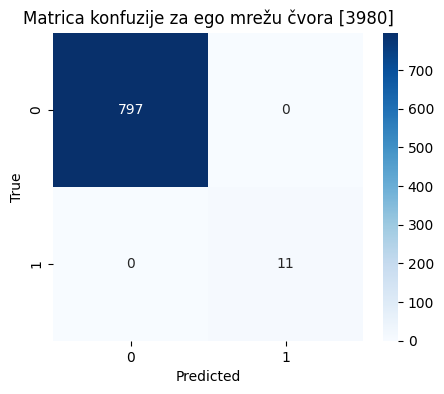

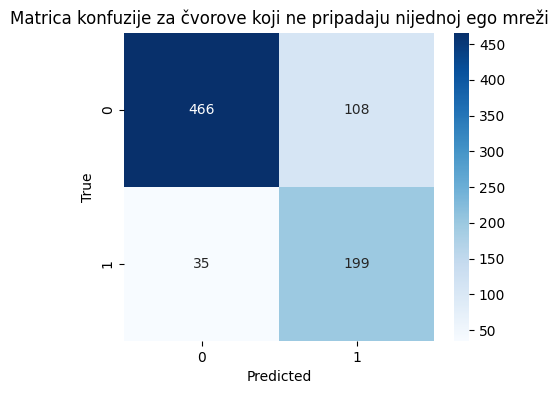

Test Loss: 0.2296
Test Accuracy: 0.9490
Test Precision: 0.6758
Test Recall: 0.9728
Test F1 Score: 0.7603


In [15]:
# Pokreni testiranje sa najboljim parametrima
hidden_channels, dropout_rate, num_epochs = best_params
print(f'Testing the best model with parameters: {best_params}')

# inicijalizacija modela sa najboljim parametrima
model = GCN(in_channels=node_features.shape[1], hidden_channels=hidden_channels, out_channels=labels.shape[1], dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

for epoch in range(num_epochs):
    loss_train, acc_train, precision_train, recall_train, f1_train = train()

test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate(data.test_mask)

# prikaz rezultata na test skupu
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')